# Лабораторная работа 7
Исследоване сегментации


Датасет семантической сегментации растений в почве


Датасет: https://www.kaggle.com/datasets/killa92/plant-semantic-segmentation


Датасет выбран из-за особой актуальности для России, у которой большая часть оборота построена на сельхоз-сфере. Это задача является реальной, и сильно бы помогла обнарживать растения в почвах для фермеров, биологов и обычных любителей. В последствии, можно будет находить и остатки ископаемых

In [ ]:
!rm -rf masks/

In [ ]:
!unzip archive.zip

Archive:  archive.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of archive.zip or
        archive.zip.zip, and cannot find archive.zip.ZIP, period.


In [ ]:
!ls


archive.zip  sample_data


In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
import random



In [ ]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import os
import cv2
import torch
import numpy as np
import albumentations as A
from torch.utils.data import Dataset, DataLoader, random_split
import segmentation_models_pytorch as smp


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:


import opendatasets as od

od.download("https://www.kaggle.com/datasets/sadhliroomyprime/motorcycle-night-ride-semantic-segmentation")



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Alice
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sadhliroomyprime/motorcycle-night-ride-semantic-segmentation


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Метрики
В рамках данной задачи в качестве метрик качества будут использоваться Pixel Accuracy и Intersection over Union (IoU). Первая отражает долю пикселей, которые были правильно классифицированы, относительно общего количества пикселей на изображении. Вторая метрика, IoU, оценивает степень совпадения предсказанного и истинного расположения объекта. Она рассчитывается как отношение площади пересечения двух ограничивающих прямоугольников к площади их объединения. Значение IoU варьируется от 0 до 1, где 0 указывает на полное отсутствие пересечения, а 1 — на идеальное совпадение.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("killa92/plant-semantic-segmentation")

print("Path to dataset files:", path)

100%|██████████| 1.38G/1.38G [01:09<00:00, 21.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/killa92/plant-semantic-segmentation/versions/1


In [ ]:
import shutil
import os

source_dir = "/root/.cache/kagglehub/datasets/killa92/plant-semantic-segmentation/versions/1"
dest_dir = "/content/plant_dataset"

os.makedirs(dest_dir, exist_ok=True)

shutil.copytree(source_dir, dest_dir, dirs_exist_ok=True)

print(f"Датасет скопирован в {dest_dir}")

Датасет скопирован в /content/plant_dataset


In [ ]:
!rm -rf plant_dataset


In [ ]:

!pip install segmentation-models-pytorch


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Создание бейслайна и оценка качества

In [ ]:
root_ds = './Plant segmentation'

In [ ]:
import torch, os, cv2, numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import matplotlib.pyplot as plt
import albumentations as A
from glob import glob
from tqdm import tqdm
import segmentation_models_pytorch as smp
from PIL import Image

In [ ]:


class Segmentations(Dataset):
    def __init__(self, root, transformations=None):
        self.transformations = transformations
        self.tensorize = T.Compose([T.ToTensor()])
        self.im_path_jpg = sorted(glob(f"{root}/images/*"))
        self.im_mask_png = sorted(glob(f"{root}/masks/*"))

        self.total_ims = len(self.im_path_jpg)
        self.total_gts = len(self.im_mask_png)

        assert self.total_ims == self.total_gts
        print(f'There are {self.total_ims} images and {self.total_gts} masks in the dataset')

    def __len__(self):
        return len(self.im_path_jpg)

    def __getitem__(self, idx):
        im = np.array(Image.open(self.im_path_jpg[idx]).convert('RGB'))
        gt = np.array(Image.open(self.im_mask_png[idx]).convert("L"))

        if self.transformations is not None:
            transformed = self.transformations(image=im, mask=gt)
            im, gt = transformed['image'], transformed['mask']

        return self.tensorize(im), torch.tensor(gt > 128).long()


def get_transformation(size):
    tfs = A.Compose([A.Resize(size, size)])
    return tfs

tfs = get_transformation(256)
ds = Segmentations(root=root_ds, transformations=tfs)
print(type(ds[0][0]))
print(ds[0][1].shape)



There are 144 images and 144 masks in the dataset
<class 'torch.Tensor'>
torch.Size([256, 256])


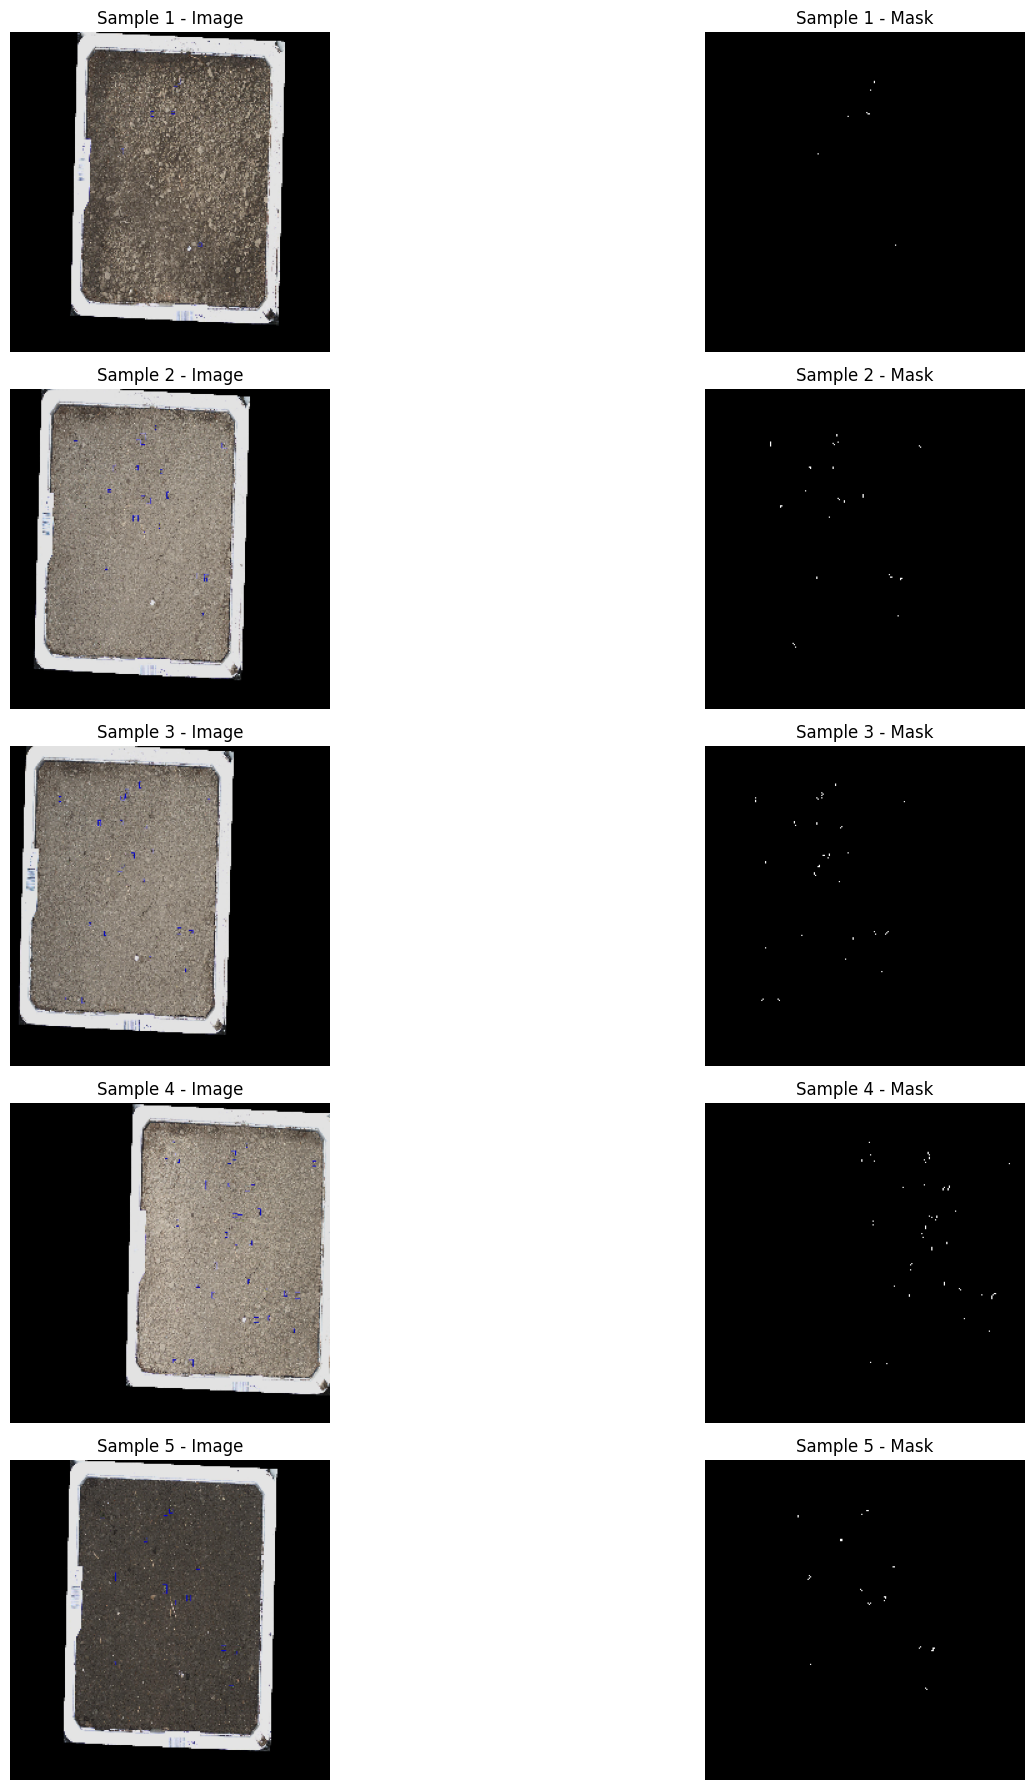

In [ ]:
import matplotlib.pyplot as plt
import torch

def display_samples(dataset, num_samples=10, images_per_row=2):
    plt.figure(figsize=(18, 18))

    for idx, (image, mask) in enumerate(dataset):
        if idx >= num_samples:
            break
        image_np = (image * 255).detach().cpu().permute(1, 2, 0).numpy().astype('uint8')
        mask_np = (mask * 255).detach().cpu().squeeze().numpy().astype('uint8')
        pos1 = idx * 2 + 1
        pos2 = idx * 2 + 2

        plt.subplot(num_samples, images_per_row, pos1)
        plt.imshow(image_np)
        plt.title(f'Sample {idx+1} - Image')
        plt.axis('off')
        plt.subplot(num_samples, images_per_row, pos2)
        plt.imshow(mask_np, cmap='gray')
        plt.title(f'Sample {idx+1} - Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_samples(ds, num_samples=5, images_per_row=2)

In [ ]:
def get_dl(root, transformations, bs, split = [0.7, 0.15, 0.15]):

    ds = Segmentations(root=root_ds, transformations=tfs)

    tr_len = int(split[0] * len(ds))
    val_len = int(split[1] * len(ds))
    test_len = len(ds) - (tr_len + val_len)
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])

    print(f"There are {len(tr_ds)} images in the trainset")
    print(f"There are {len(val_ds)} images in the validation set")
    print(f"There are {len(test_ds)} images in the test set")

    tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False)

    print(len(tr_dl))
    print(len(val_dl))
    print(len(test_dl))


    return tr_dl, val_dl, test_dl



tr_dl, val_dl, test_dl = get_dl(root = "data", bs = 4, transformations = tfs)

There are 144 images and 144 masks in the dataset
There are 100 images in the trainset
There are 21 images in the validation set
There are 23 images in the test set
25
6
23


In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from typing import Tuple, List, Optional

def get_data_loaders(
    root: str,
    transformations: Optional[object],
    batch_size: int,
    split_ratios: List[float] = [0.7, 0.15, 0.15],
    verbose: bool = True
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    try:
        dataset = Segmentations(root=root, transformations=transformations)

        if len(dataset) == 0:
            raise ValueError("Dataset is empty - check your data paths")
        train_size = int(split_ratios[0] * len(dataset))
        val_size = int(split_ratios[1] * len(dataset))
        test_size = len(dataset) - train_size - val_size
        train_ds, val_ds, test_ds = random_split(
            dataset,
            [train_size, val_size, test_size]
        )

        if verbose:
            print_dataset_stats(train_ds, val_ds, test_ds, batch_size)
        train_loader = create_loader(train_ds, batch_size, shuffle=True)
        val_loader = create_loader(val_ds, batch_size, shuffle=False)
        test_loader = create_loader(test_ds, 1, shuffle=False)

        return train_loader, val_loader, test_loader

    except Exception as e:
        print(f"Error creating data loaders: {str(e)}")
        raise

def print_dataset_stats(
    train_ds: torch.utils.data.Dataset,
    val_ds: torch.utils.data.Dataset,
    test_ds: torch.utils.data.Dataset,
    batch_size: int
) -> None:
    print("\nDataset Statistics:")
    print(f"- {'Training set:':<20} {len(train_ds):>5} images")
    print(f"- {'Validation set:':<20} {len(val_ds):>5} images")
    print(f"- {'Test set:':<20} {len(test_ds):>5} images")

    print("\nNumber of batches:")
    print(f"- {'Training:':<12} {len(train_ds) // batch_size:>3} (batch size: {batch_size})")
    print(f"- {'Validation:':<12} {len(val_ds) // batch_size:>3} (batch size: {batch_size})")
    print(f"- {'Test:':<12} {len(test_ds):>3} (batch size: 1)")

def create_loader(
    dataset: torch.utils.data.Dataset,
    batch_size: int,
    shuffle: bool = False
) -> DataLoader:
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=True,
        num_workers=2
    )

try:
    train_loader, val_loader, test_loader = get_data_loaders(
        root=root_ds,
        transformations=tfs,
        batch_size=4,
        split_ratios=[0.7, 0.15, 0.15]
    )
except Exception as e:
    print(f"Failed to create data loaders: {e}")

There are 144 images and 144 masks in the dataset

Dataset Statistics:
- Training set:          100 images
- Validation set:         21 images
- Test set:               23 images

Number of batches:
- Training:     25 (batch size: 4)
- Validation:    5 (batch size: 4)
- Test:         23 (batch size: 1)


In [ ]:
class Metrics():

    def __init__(self, pred, gt, loss_fn, eps = 3e-4, n_cls = 2):


        self.pred_ = pred
        self.pred, self.gt = torch.argmax(torch.nn.functional.softmax(pred, dim = 1)), gt
        self.pred, self.gt = torch.argmax(torch.nn.functional.softmax(pred, dim = 1), dim = 1), gt
        self.loss_fn, self.eps, self.n_cls = loss_fn, eps, n_cls

    def to_contiguous(self, inp):
       return inp.contiguous().view(-1)

    def PA(self): # pixel accuracy
        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        return float(match.sum()) / float(match.numel())

    def mIoU(self):

        with torch.no_grad():
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
            iou_per_class = []
            for c in range(self.n_cls):
                match_pred = pred == c
                match_gt= gt== c
                if match_gt.long().sum().item() == 0:
                   iou_per_class.append(np.nan)
                else:
                    intersection = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()
                    iou = (intersection) / (union + self.eps)
                    iou_per_class.append(iou)
            return np.nanmean(iou_per_class)

    def loss(self):
       return self.loss_fn(self.pred_, self.gt)

In [ ]:
model = smp.Unet(encoder_name = 'resnet18',
               encoder_weights = 'imagenet',
               in_channels = 3,
               classes = 2,
               encoder_depth = 5,
               decoder_channels = [256,128,64,32,16])
model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params = model.parameters(), lr = 3e-2)

In [ ]:
from tqdm import tqdm
import torch
from typing import Dict, Tuple, Callable
from pathlib import Path
from tabulate import tabulate

def train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    patience: int,
    save_path: str = "/content/best_model.pth"
) -> Dict[str, list]:
    metrics = {
        'train_loss': [], 'train_pa': [], 'train_iou': [],
        'val_loss': [], 'val_pa': [], 'val_iou': []
    }

    best_loss = float('inf')
    not_improved = 0
    model.to(device)

    Path(save_path).parent.mkdir(parents=True, exist_ok=True)

    for epoch in range(1, epochs + 1):
        model.train()
        train_metrics = _run_epoch(
            model=model,
            loader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            mode='train',
            epoch_num=epoch
        )

        model.eval()
        val_metrics = _run_epoch(
            model=model,
            loader=val_loader,
            loss_fn=loss_fn,
            optimizer=None,
            device=device,
            mode='val',
            epoch_num=epoch
        )

        for key in train_metrics:
            metrics[f'train_{key}'].append(train_metrics[key].item() if torch.is_tensor(train_metrics[key]) else train_metrics[key])
            metrics[f'val_{key}'].append(val_metrics[key].item() if torch.is_tensor(val_metrics[key]) else val_metrics[key])

        _print_epoch_summary(epoch, train_metrics, val_metrics)
        current_val_loss = val_metrics['loss']
        if current_val_loss < best_loss:
            print(f"Loss improved from {best_loss:.4f} to {current_val_loss:.4f}")
            best_loss = current_val_loss
            torch.save(model.state_dict(), save_path)
            not_improved = 0
        else:
            not_improved += 1
            if not_improved >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    return metrics

def _run_epoch(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    loss_fn: Callable,
    device: torch.device,
    mode: str,
    epoch_num: int,
    optimizer: torch.optim.Optimizer = None
) -> Dict[str, float]:
    is_train = optimizer is not None
    total_loss = 0.0
    total_pa = 0.0
    total_iou = 0.0

    with torch.set_grad_enabled(is_train):
        desc = f"Эпоха {epoch_num} {mode}"
        for batch in tqdm(loader, desc=desc):
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            metrics = Metrics(pred=outputs, gt=masks, loss_fn=loss_fn)
            batch_loss = metrics.loss()
            total_loss += batch_loss.item() if not is_train else batch_loss
            total_pa += metrics.PA()
            total_iou += metrics.mIoU()
            if is_train:
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

    num_batches = len(loader)
    return {
        'loss': total_loss / num_batches,
        'pa': total_pa / num_batches,
        'iou': total_iou / num_batches
    }

def _print_epoch_summary(epoch, train_metrics, val_metrics):
    table = [
        ["Loss", f"{train_metrics['loss']:.4f}", f"{val_metrics['loss']:.4f}"],
        ["PA", f"{train_metrics['pa']:.4f}", f"{val_metrics['pa']:.4f}"],
        ["IoU", f"{train_metrics['iou']:.4f}", f"{val_metrics['iou']:.4f}"]
    ]
    print(f"\nEpoch {epoch} Summary:")
    print(tabulate(table, headers=["Metric", "Training", "Validation"], tablefmt="grid"))

In [ ]:
results = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters()),
    epochs=5,
    device=device,
    patience=5,
    save_path="/content/best_segmentation_model.pth"
)

Эпоха 1 val: 100%|██████████| 6/6 [00:10<00:00,  1.69s/it]



Epoch 1 Summary:
+----------+------------+--------------+
| Metric   |   Training |   Validation |
+==========+============+==============+
| Loss     |     0.0446 |       0.0442 |
+----------+------------+--------------+
| PA       |     0.9813 |       0.9835 |
+----------+------------+--------------+
| IoU      |     0.7796 |       0.736  |
+----------+------------+--------------+
Loss improved from inf to 0.0442


Эпоха 2 val: 100%|██████████| 6/6 [00:09<00:00,  1.51s/it]



Epoch 2 Summary:
+----------+------------+--------------+
| Metric   |   Training |   Validation |
+==========+============+==============+
| Loss     |     0.0412 |       0.0406 |
+----------+------------+--------------+
| PA       |     0.9826 |       0.9845 |
+----------+------------+--------------+
| IoU      |     0.7905 |       0.7064 |
+----------+------------+--------------+
Loss improved from 0.0442 to 0.0406


Эпоха 3 val: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]



Epoch 3 Summary:
+----------+------------+--------------+
| Metric   |   Training |   Validation |
+==========+============+==============+
| Loss     |     0.0391 |       0.0364 |
+----------+------------+--------------+
| PA       |     0.9831 |       0.9848 |
+----------+------------+--------------+
| IoU      |     0.7869 |       0.7235 |
+----------+------------+--------------+
Loss improved from 0.0406 to 0.0364


Эпоха 4 val: 100%|██████████| 6/6 [00:11<00:00,  1.95s/it]



Epoch 4 Summary:
+----------+------------+--------------+
| Metric   |   Training |   Validation |
+==========+============+==============+
| Loss     |     0.038  |       0.0366 |
+----------+------------+--------------+
| PA       |     0.9834 |       0.9847 |
+----------+------------+--------------+
| IoU      |     0.7932 |       0.707  |
+----------+------------+--------------+


Эпоха 5 val: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]



Epoch 5 Summary:
+----------+------------+--------------+
| Metric   |   Training |   Validation |
+==========+============+==============+
| Loss     |     0.0375 |       0.0348 |
+----------+------------+--------------+
| PA       |     0.9835 |       0.9846 |
+----------+------------+--------------+
| IoU      |     0.7925 |       0.744  |
+----------+------------+--------------+
Loss improved from 0.0364 to 0.0348


Функция построения графика

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List

def plot_training_history(history: Dict[str, List[float]],
                          figsize: tuple = (18, 6),
                          smooth: bool = True,
                          window_size: int = 3 ) -> None:
    metrics = {
        'Loss': (history['train_loss'], history['val_loss']),
        'Pixel Accuracy': (history['train_pa'], history['val_pa']),
        'IoU': (history['train_iou'], history['val_iou'])
    }

    def smooth_curve(data: List[float]) -> List[float]:
        if len(data) < window_size:
            return data
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    if smooth:
        metrics = {
            name: (smooth_curve(train), smooth_curve(val))
            for name, (train, val) in metrics.items()
        }

    plt.figure(figsize=figsize)
    for i, (title, (train_vals, val_vals)) in enumerate(metrics.items(), 1):
        plt.subplot(1, 3, i)
        epochs = range(1, len(train_vals) + 1)
        plt.plot(epochs, train_vals, label='Train', linewidth=2)
        plt.plot(epochs, val_vals, label='Validation', linewidth=2)

        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel(title)
        plt.grid(True)

        if 'Accuracy' in title or 'IoU' in title:
            plt.ylim(0, 1.05)

        best_val = max(val_vals) if title != 'Loss' else min(val_vals)
        best_epoch = np.argmax(val_vals) if title != 'Loss' else np.argmin(val_vals)
        plt.annotate(f'Best: {best_val:.3f}\nEpoch: {best_epoch+1}',
                     xy=(best_epoch+1, best_val),
                     xytext=(10, 10),
                     textcoords='offset points',
                     bbox=dict(boxstyle='round', fc='w', alpha=0.8),
                     fontsize=10)

        if i == 1:
            plt.legend()

    plt.tight_layout()
    plt.show()


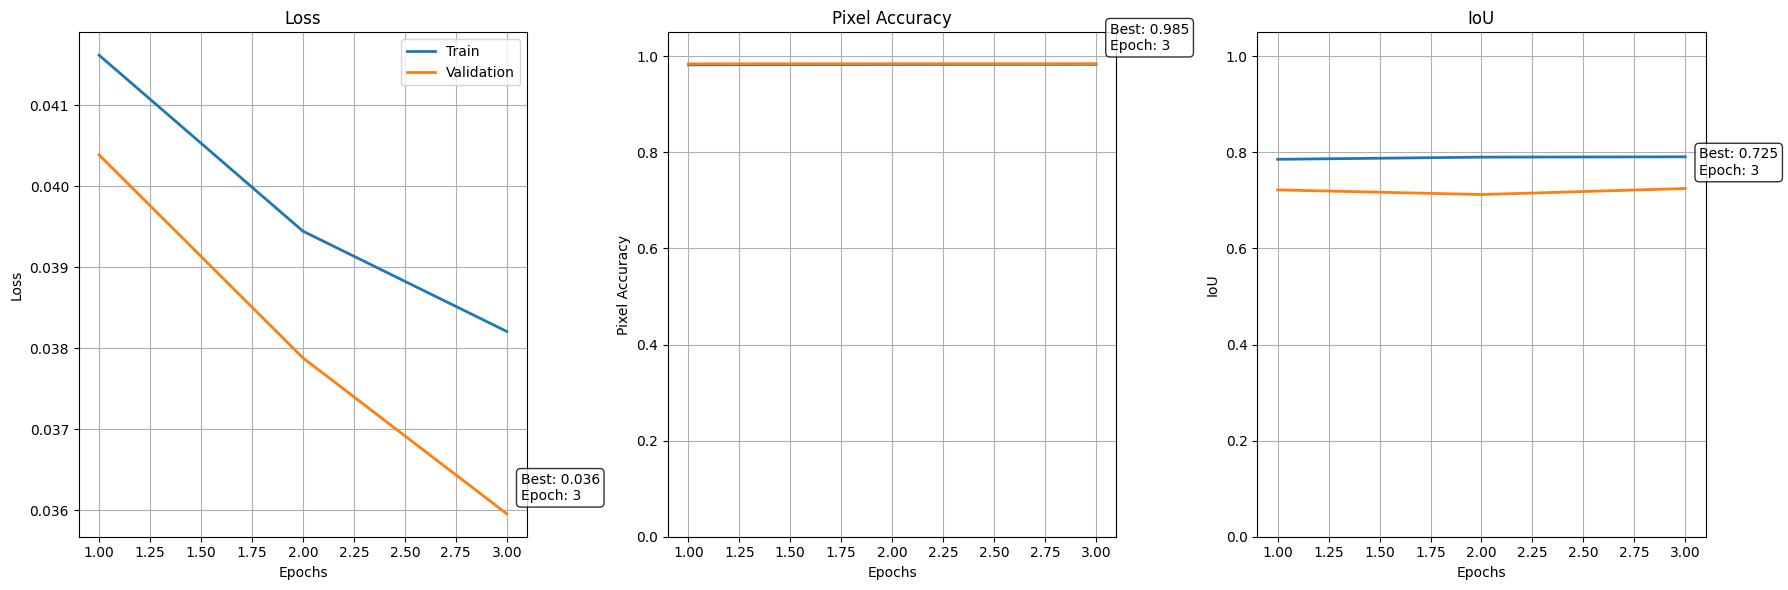

In [ ]:
plot_training_history(results)

In [ ]:
!pwd


/content


## Улучшим бейслайн

*   сделаем encoder ResNet50
*   добавим более сбалансирвоанные размеры каналов
*   добавим комбинированную функцию потерь
*   добавим sgeduler для learning rate




In [ ]:
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=2,
    encoder_depth=5,
    decoder_channels=[256, 128, 64, 32, 16]
)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss()
        self.dice = smp.losses.DiceLoss(mode='multiclass')

    def forward(self, pred, target):
        return self.alpha * self.ce(pred, target) + (1 - self.alpha) * self.dice(pred, target)

In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from typing import Dict, Tuple, Callable
from pathlib import Path
from tabulate import tabulate

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

def train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler,
    epochs: int,
    device: torch.device,
    patience: int,
    save_path: str = "/content/best_model.pth"
) -> Dict[str, list]:
    metrics = {
        'train_loss': [], 'train_pa': [], 'train_iou': [],
        'val_loss': [], 'val_pa': [], 'val_iou': [],
        'lr': []
    }

    best_loss = float('inf')
    not_improved = 0
    model.to(device)

    Path(save_path).parent.mkdir(parents=True, exist_ok=True)

    for epoch in range(1, epochs + 1):
        model.train()
        train_metrics = _run_epoch(
            model=model,
            loader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            mode='train',
            epoch_num=epoch
        )

        model.eval()
        val_metrics = _run_epoch(
            model=model,
            loader=val_loader,
            loss_fn=loss_fn,
            optimizer=None,
            device=device,
            mode='val',
            epoch_num=epoch
        )

        scheduler.step(val_metrics['loss'])
        current_lr = optimizer.param_groups[0]['lr']
        metrics['lr'].append(current_lr)

        for key in train_metrics:
            metrics[f'train_{key}'].append(train_metrics[key].item() if torch.is_tensor(train_metrics[key]) else train_metrics[key])
            metrics[f'val_{key}'].append(val_metrics[key].item() if torch.is_tensor(val_metrics[key]) else val_metrics[key])

        _print_epoch_summary(epoch, train_metrics, val_metrics, current_lr)

        current_val_loss = val_metrics['loss']
        if current_val_loss < best_loss:
            print(f"Loss improved from {best_loss:.4f} to {current_val_loss:.4f}")
            best_loss = current_val_loss
            torch.save(model.state_dict(), save_path)
            not_improved = 0
        else:
            not_improved += 1
            if not_improved >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    return metrics

def _print_epoch_summary(epoch, train_metrics, val_metrics, lr):
    table = [
        ["Loss", f"{train_metrics['loss']:.4f}", f"{val_metrics['loss']:.4f}"],
        ["PA", f"{train_metrics['pa']:.4f}", f"{val_metrics['pa']:.4f}"],
        ["IoU", f"{train_metrics['iou']:.4f}", f"{val_metrics['iou']:.4f}"],
        ["LR", f"{lr:.2e}", ""]
    ]
    print(f"\nEpoch {epoch} Summary:")
    print(tabulate(table, headers=["Metric", "Training", "Validation"], tablefmt="grid"))

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
loss_fn = CombinedLoss(alpha=0.6)

In [ ]:
results_2 = train_model(
    model=model,
    train_loader=tr_dl,
    val_loader=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=12,
    device=device,
    patience=5
)

Эпоха 1 val: 100%|██████████| 6/6 [00:11<00:00,  1.98s/it]



Epoch 1 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.532  | 0.4595       |
+----------+------------+--------------+
| PA       |     0.7933 | 0.9138       |
+----------+------------+--------------+
| IoU      |     0.4361 | 0.4769       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from inf to 0.4595


Эпоха 2 val: 100%|██████████| 6/6 [00:12<00:00,  2.02s/it]



Epoch 2 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.3956 | 0.3450       |
+----------+------------+--------------+
| PA       |     0.9428 | 0.9673       |
+----------+------------+--------------+
| IoU      |     0.6037 | 0.6492       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.4595 to 0.3450


Эпоха 3 val: 100%|██████████| 6/6 [00:12<00:00,  2.02s/it]



Epoch 3 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.3175 | 0.2834       |
+----------+------------+--------------+
| PA       |     0.968  | 0.9773       |
+----------+------------+--------------+
| IoU      |     0.6682 | 0.6994       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.3450 to 0.2834


Эпоха 4 val: 100%|██████████| 6/6 [00:11<00:00,  1.99s/it]



Epoch 4 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.2676 | 0.2439       |
+----------+------------+--------------+
| PA       |     0.9727 | 0.9794       |
+----------+------------+--------------+
| IoU      |     0.7109 | 0.7134       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.2834 to 0.2439


Эпоха 5 val: 100%|██████████| 6/6 [00:11<00:00,  1.99s/it]



Epoch 5 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.2369 | 0.2444       |
+----------+------------+--------------+
| PA       |     0.9749 | 0.9590       |
+----------+------------+--------------+
| IoU      |     0.725  | 0.6890       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+


Эпоха 6 val: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]



Epoch 6 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.2142 | 0.2030       |
+----------+------------+--------------+
| PA       |     0.9764 | 0.9786       |
+----------+------------+--------------+
| IoU      |     0.7353 | 0.7164       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.2439 to 0.2030


Эпоха 7 val: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]



Epoch 7 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.1955 | 0.1854       |
+----------+------------+--------------+
| PA       |     0.9771 | 0.9820       |
+----------+------------+--------------+
| IoU      |     0.7438 | 0.7320       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.2030 to 0.1854


Эпоха 8 val: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]



Epoch 8 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.181  | 0.1749       |
+----------+------------+--------------+
| PA       |     0.9783 | 0.9829       |
+----------+------------+--------------+
| IoU      |     0.7472 | 0.7346       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.1854 to 0.1749


Эпоха 9 val: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]



Epoch 9 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.169  | 0.1644       |
+----------+------------+--------------+
| PA       |     0.9789 | 0.9827       |
+----------+------------+--------------+
| IoU      |     0.7547 | 0.7375       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.1749 to 0.1644


Эпоха 10 val: 100%|██████████| 6/6 [00:11<00:00,  1.98s/it]



Epoch 10 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.1557 | 0.1572       |
+----------+------------+--------------+
| PA       |     0.9797 | 0.9827       |
+----------+------------+--------------+
| IoU      |     0.7669 | 0.7388       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.1644 to 0.1572


Эпоха 11 val: 100%|██████████| 6/6 [00:11<00:00,  1.99s/it]



Epoch 11 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.1522 | 0.1520       |
+----------+------------+--------------+
| PA       |     0.9797 | 0.9829       |
+----------+------------+--------------+
| IoU      |     0.7605 | 0.7411       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.1572 to 0.1520


Эпоха 12 val: 100%|██████████| 6/6 [00:10<00:00,  1.80s/it]



Epoch 12 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.145  | 0.1507       |
+----------+------------+--------------+
| PA       |     0.9801 | 0.9807       |
+----------+------------+--------------+
| IoU      |     0.7635 | 0.7392       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.1520 to 0.1507


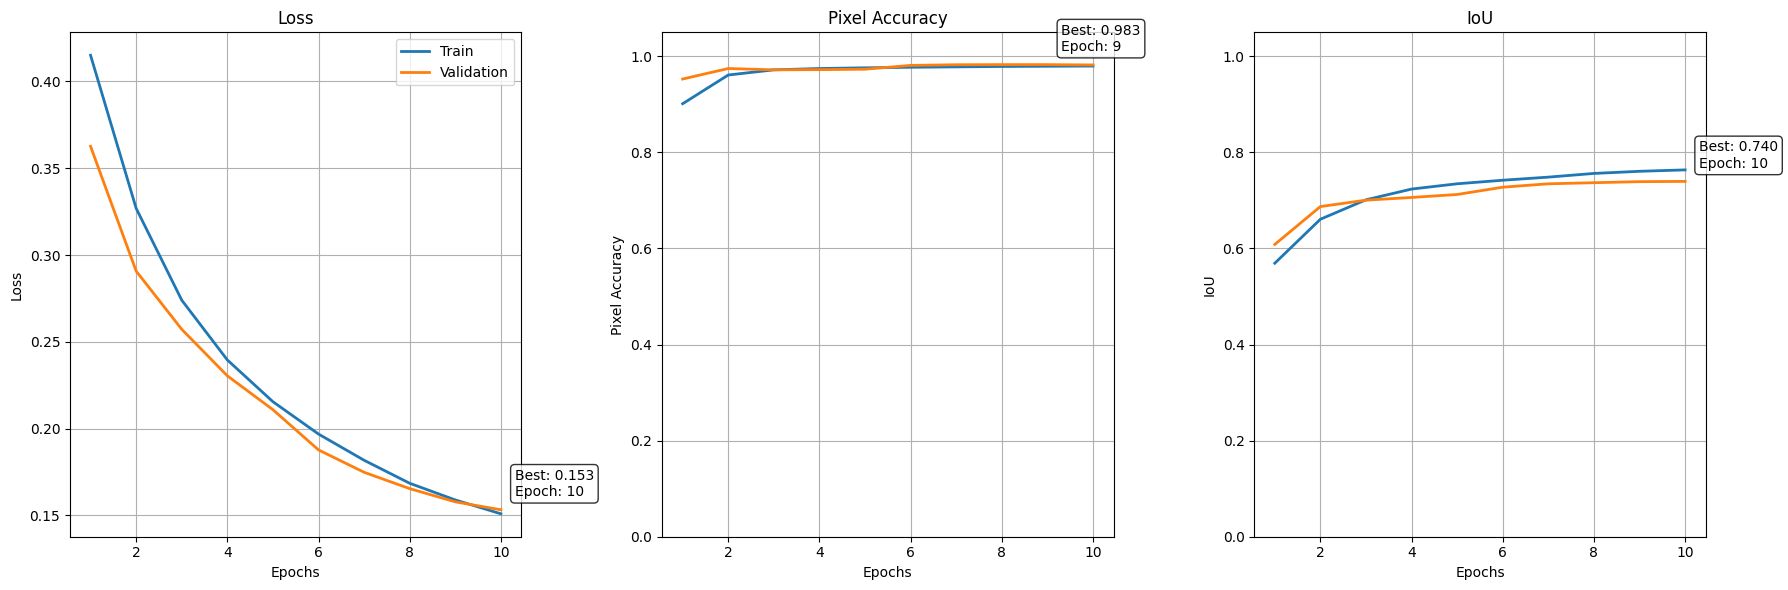

In [ ]:
plot_training_history(results_2)

# Выводы

Благодаря выбранным способом улучшения бейслайна получилти столь отличные результаты, как и ранее. Почти не видны улучшения потому что изначально и так все отлично считалось и показывало хорошие метрики
Однако наблюдая за эпохами можно заметить, что UNet немного переобучилась, стоило бы уменьшить колчичество эпох


#  Имплементация алгоритма машинного обучения

In [ ]:
import torch
import torch.nn as nn

class MyUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super().__init__()
        self.encoder1 = self.conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = self.conv_block(256, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder3 = self.conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = self.conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.encoder1(x)
        p1 = self.pool1(e1)

        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)

        e3 = self.encoder3(p2)
        p3 = self.pool3(e3)


        b = self.bottleneck(p3)
        u3 = self.up3(b)
        d3 = self.decoder3(torch.cat([u3, e3], dim=1))

        u2 = self.up2(d3)
        d2 = self.decoder2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        d1 = self.decoder1(torch.cat([u1, e1], dim=1))

        return self.classifier(d1)


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params = model.parameters(), lr = 3e-2)

In [ ]:
from tqdm import tqdm
import torch
from typing import Dict, Tuple, Callable
from pathlib import Path
from tabulate import tabulate

def train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    patience: int,
    save_path: str = "/content/best_model.pth"
) -> Dict[str, list]:
    metrics = {
        'train_loss': [], 'train_pa': [], 'train_iou': [],
        'val_loss': [], 'val_pa': [], 'val_iou': []
    }

    best_loss = float('inf')
    not_improved = 0
    model.to(device)

    Path(save_path).parent.mkdir(parents=True, exist_ok=True)

    for epoch in range(1, epochs + 1):
        model.train()
        train_metrics = _run_epoch(
            model=model,
            loader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            mode='train',
            epoch_num=epoch
        )

        model.eval()
        val_metrics = _run_epoch(
            model=model,
            loader=val_loader,
            loss_fn=loss_fn,
            optimizer=None,
            device=device,
            mode='val',
            epoch_num=epoch
        )

        for key in train_metrics:
            metrics[f'train_{key}'].append(train_metrics[key].item() if torch.is_tensor(train_metrics[key]) else train_metrics[key])
            metrics[f'val_{key}'].append(val_metrics[key].item() if torch.is_tensor(val_metrics[key]) else val_metrics[key])

        _print_epoch_summary(epoch, train_metrics, val_metrics)
        current_val_loss = val_metrics['loss']
        if current_val_loss < best_loss:
            print(f"Loss improved from {best_loss:.4f} to {current_val_loss:.4f}")
            best_loss = current_val_loss
            torch.save(model.state_dict(), save_path)
            not_improved = 0
        else:
            not_improved += 1
            if not_improved >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    return metrics

def _run_epoch(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    loss_fn: Callable,
    device: torch.device,
    mode: str,
    epoch_num: int,
    optimizer: torch.optim.Optimizer = None
) -> Dict[str, float]:
    is_train = optimizer is not None
    total_loss = 0.0
    total_pa = 0.0
    total_iou = 0.0

    with torch.set_grad_enabled(is_train):
        desc = f"Эпоха {epoch_num} {mode}"
        for batch in tqdm(loader, desc=desc):
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            metrics = Metrics(pred=outputs, gt=masks, loss_fn=loss_fn)
            batch_loss = metrics.loss()
            total_loss += batch_loss.item() if not is_train else batch_loss
            total_pa += metrics.PA()
            total_iou += metrics.mIoU()
            if is_train:
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

    num_batches = len(loader)
    return {
        'loss': total_loss / num_batches,
        'pa': total_pa / num_batches,
        'iou': total_iou / num_batches
    }

def _print_epoch_summary(epoch, train_metrics, val_metrics):
    table = [
        ["Loss", f"{train_metrics['loss']:.4f}", f"{val_metrics['loss']:.4f}"],
        ["PA", f"{train_metrics['pa']:.4f}", f"{val_metrics['pa']:.4f}"],
        ["IoU", f"{train_metrics['iou']:.4f}", f"{val_metrics['iou']:.4f}"]
    ]
    print(f"\nEpoch {epoch} Summary:")
    print(tabulate(table, headers=["Metric", "Training", "Validation"], tablefmt="grid"))

In [ ]:

model = MyUNet(num_classes=11).to(device)

In [ ]:
results = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters()),
    epochs=5,
    device=device,
    patience=5,
    save_path="/content/best_segmentation_model.pth"
)

Эпоха 1 val: 100%|██████████| 6/6 [00:09<00:00,  1.53s/it]



Epoch 1 Summary:
+----------+------------+--------------+
| Metric   |   Training |   Validation |
+==========+============+==============+
| Loss     |     0.665  |       0.1029 |
+----------+------------+--------------+
| PA       |     0.8634 |       0.9739 |
+----------+------------+--------------+
| IoU      |     0.4318 |       0.487  |
+----------+------------+--------------+
Loss improved from inf to 0.1029


Эпоха 2 val: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]



Epoch 2 Summary:
+----------+------------+--------------+
| Metric   |   Training |   Validation |
+==========+============+==============+
| Loss     |     0.1358 |       0.099  |
+----------+------------+--------------+
| PA       |     0.9617 |       0.9739 |
+----------+------------+--------------+
| IoU      |     0.4808 |       0.487  |
+----------+------------+--------------+
Loss improved from 0.1029 to 0.0990


Эпоха 3 val: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]



Epoch 3 Summary:
+----------+------------+--------------+
| Metric   |   Training |   Validation |
+==========+============+==============+
| Loss     |     0.1221 |       0.0942 |
+----------+------------+--------------+
| PA       |     0.9617 |       0.9739 |
+----------+------------+--------------+
| IoU      |     0.4808 |       0.487  |
+----------+------------+--------------+
Loss improved from 0.0990 to 0.0942


Эпоха 4 val: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]



Epoch 4 Summary:
+----------+------------+--------------+
| Metric   |   Training |   Validation |
+==========+============+==============+
| Loss     |     0.116  |       0.0902 |
+----------+------------+--------------+
| PA       |     0.9617 |       0.9739 |
+----------+------------+--------------+
| IoU      |     0.4808 |       0.487  |
+----------+------------+--------------+
Loss improved from 0.0942 to 0.0902


Эпоха 5 val: 100%|██████████| 6/6 [00:09<00:00,  1.60s/it]


Epoch 5 Summary:
+----------+------------+--------------+
| Metric   |   Training |   Validation |
+==========+============+==============+
| Loss     |     0.1076 |       0.0785 |
+----------+------------+--------------+
| PA       |     0.9617 |       0.9739 |
+----------+------------+--------------+
| IoU      |     0.4808 |       0.487  |
+----------+------------+--------------+
Loss improved from 0.0902 to 0.0785


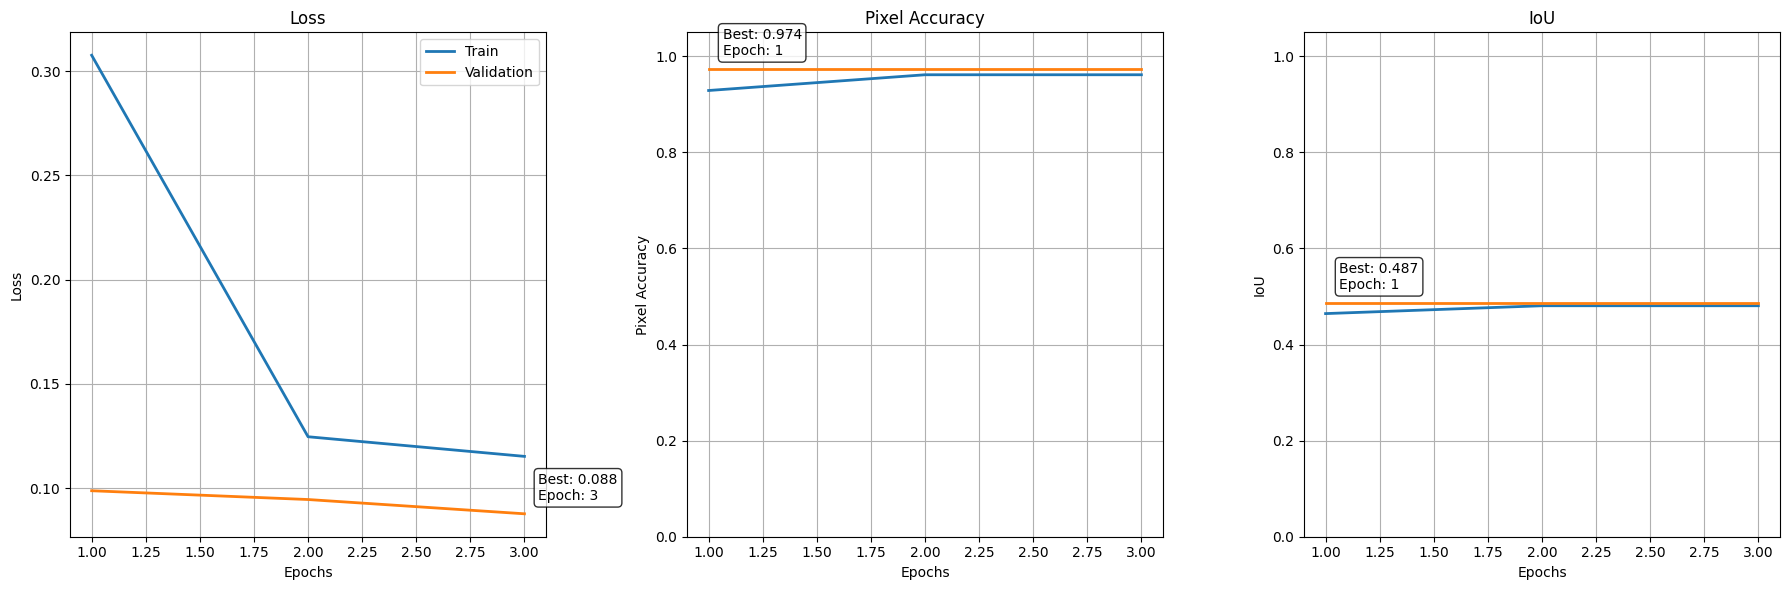

In [ ]:
plot_training_history(results)

## Улучшение бейслайна
 применим те же эвристики, только саму модель не будем особо изменять, так как при таких параметрах она показывает хорошие результаты

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

def train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler,
    epochs: int,
    device: torch.device,
    patience: int,
    save_path: str = "/content/best_model.pth"
) -> Dict[str, list]:
    metrics = {
        'train_loss': [], 'train_pa': [], 'train_iou': [],
        'val_loss': [], 'val_pa': [], 'val_iou': [],
        'lr': []
    }

    best_loss = float('inf')
    not_improved = 0
    model.to(device)

    Path(save_path).parent.mkdir(parents=True, exist_ok=True)

    for epoch in range(1, epochs + 1):
        model.train()
        train_metrics = _run_epoch(
            model=model,
            loader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            mode='train',
            epoch_num=epoch
        )

        model.eval()
        val_metrics = _run_epoch(
            model=model,
            loader=val_loader,
            loss_fn=loss_fn,
            optimizer=None,
            device=device,
            mode='val',
            epoch_num=epoch
        )

        scheduler.step(val_metrics['loss'])
        current_lr = optimizer.param_groups[0]['lr']
        metrics['lr'].append(current_lr)

        for key in train_metrics:
            metrics[f'train_{key}'].append(train_metrics[key].item() if torch.is_tensor(train_metrics[key]) else train_metrics[key])
            metrics[f'val_{key}'].append(val_metrics[key].item() if torch.is_tensor(val_metrics[key]) else val_metrics[key])

        _print_epoch_summary(epoch, train_metrics, val_metrics, current_lr)

        current_val_loss = val_metrics['loss']
        if current_val_loss < best_loss:
            print(f"Loss improved from {best_loss:.4f} to {current_val_loss:.4f}")
            best_loss = current_val_loss
            torch.save(model.state_dict(), save_path)
            not_improved = 0
        else:
            not_improved += 1
            if not_improved >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    return metrics

def _print_epoch_summary(epoch, train_metrics, val_metrics, lr):
    table = [
        ["Loss", f"{train_metrics['loss']:.4f}", f"{val_metrics['loss']:.4f}"],
        ["PA", f"{train_metrics['pa']:.4f}", f"{val_metrics['pa']:.4f}"],
        ["IoU", f"{train_metrics['iou']:.4f}", f"{val_metrics['iou']:.4f}"],
        ["LR", f"{lr:.2e}", ""]
    ]
    print(f"\nEpoch {epoch} Summary:")
    print(tabulate(table, headers=["Metric", "Training", "Validation"], tablefmt="grid"))

In [ ]:
loss_fn = CombinedLoss(alpha=0.6)

In [ ]:
results_2_1 = train_model(
    model=model,
    train_loader=tr_dl,
    val_loader=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=10,
    device=device,
    patience=5
)

Эпоха 1 val: 100%|██████████| 6/6 [00:12<00:00,  2.05s/it]



Epoch 1 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.0526 | 0.0465       |
+----------+------------+--------------+
| PA       |     0.9791 | 0.9825       |
+----------+------------+--------------+
| IoU      |     0.7264 | 0.7281       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from inf to 0.0465


Эпоха 2 val: 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]



Epoch 2 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.0512 | 0.0449       |
+----------+------------+--------------+
| PA       |     0.979  | 0.9837       |
+----------+------------+--------------+
| IoU      |     0.727  | 0.7266       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.0465 to 0.0449


Эпоха 3 val: 100%|██████████| 6/6 [00:12<00:00,  2.06s/it]



Epoch 3 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.0501 | 0.0544       |
+----------+------------+--------------+
| PA       |     0.9794 | 0.9800       |
+----------+------------+--------------+
| IoU      |     0.7279 | 0.7232       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+


Эпоха 4 val: 100%|██████████| 6/6 [00:12<00:00,  2.08s/it]



Epoch 4 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.0504 | 0.0460       |
+----------+------------+--------------+
| PA       |     0.9793 | 0.9838       |
+----------+------------+--------------+
| IoU      |     0.7321 | 0.7146       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+


Эпоха 5 val: 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]



Epoch 5 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.0489 | 0.0428       |
+----------+------------+--------------+
| PA       |     0.9797 | 0.9843       |
+----------+------------+--------------+
| IoU      |     0.7332 | 0.7344       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.0449 to 0.0428


Эпоха 6 val: 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]



Epoch 6 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.0477 | 0.0426       |
+----------+------------+--------------+
| PA       |     0.9798 | 0.9844       |
+----------+------------+--------------+
| IoU      |     0.7438 | 0.7339       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.0428 to 0.0426


Эпоха 7 val: 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]



Epoch 7 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.0478 | 0.0426       |
+----------+------------+--------------+
| PA       |     0.9802 | 0.9843       |
+----------+------------+--------------+
| IoU      |     0.7336 | 0.7316       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+


Эпоха 8 val: 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]



Epoch 8 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.0468 | 0.0424       |
+----------+------------+--------------+
| PA       |     0.9802 | 0.9841       |
+----------+------------+--------------+
| IoU      |     0.741  | 0.7378       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+
Loss improved from 0.0426 to 0.0424


Эпоха 9 val: 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]



Epoch 9 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.0474 | 0.0504       |
+----------+------------+--------------+
| PA       |     0.9801 | 0.9813       |
+----------+------------+--------------+
| IoU      |     0.7438 | 0.7317       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+


Эпоха 10 val: 100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


Epoch 10 Summary:
+----------+------------+--------------+
| Metric   |   Training | Validation   |
+==========+============+==============+
| Loss     |     0.0522 | 0.0429       |
+----------+------------+--------------+
| PA       |     0.979  | 0.9845       |
+----------+------------+--------------+
| IoU      |     0.7119 | 0.7308       |
+----------+------------+--------------+
| LR       |     0.0001 |              |
+----------+------------+--------------+


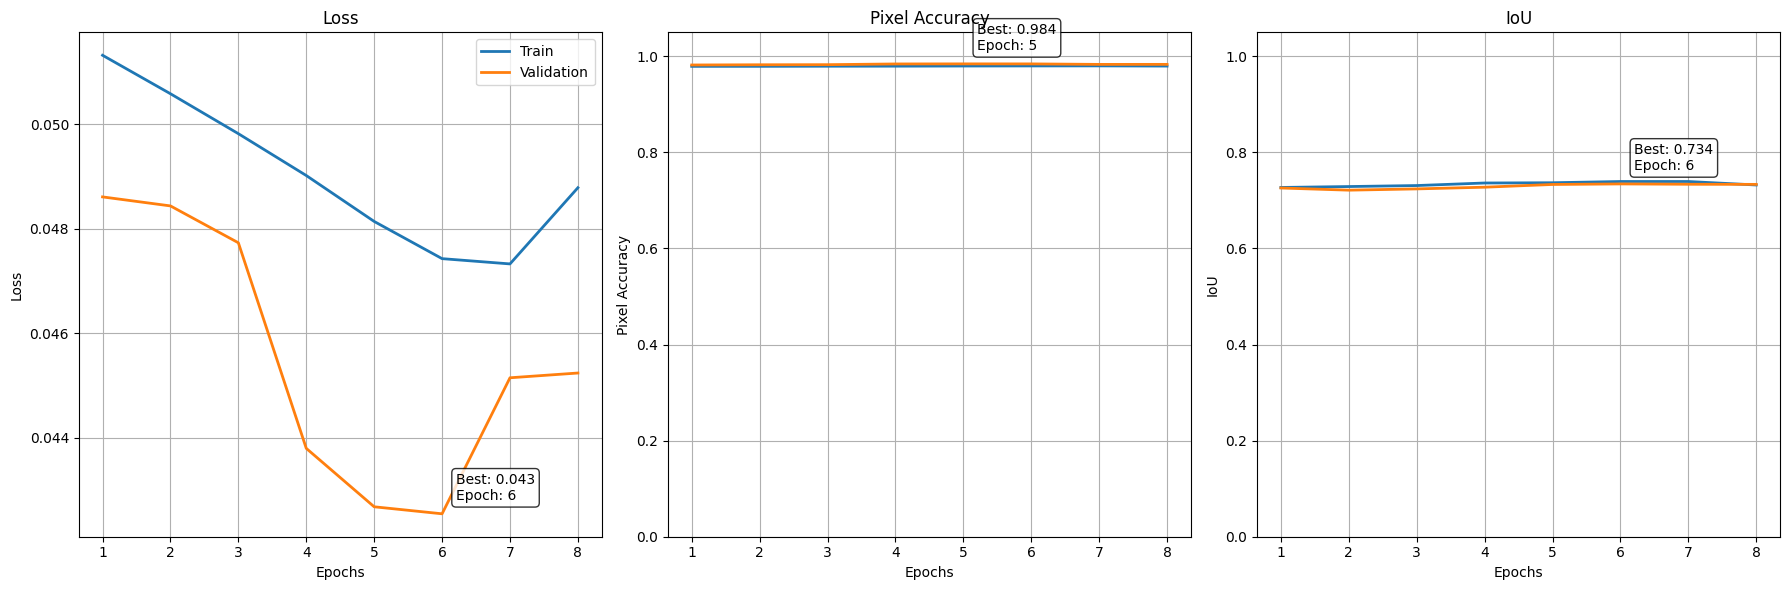

In [ ]:
plot_training_history(results_2_1)

## Выводы
как видно, графики более волнистые, но в целом справляется хорошо после улучшений, выдает отличный процент точности пикселей, iou стало чуть ниже

 так же виждно, что в этот раз, когда я поставила чуть меньше эпох обучения, у модели ненаблюдается переобучения